1) For every experiment, all the hyperparameters and data are kept constant, except the optimizers and the associated hypo-parameters. 

2) The optimizers mentioned include sgd, adagrad, adam and rmsprop.

3) The code is adopted and modified from https://github.com/caffe2/caffe2/blob/master/caffe2/python/tutorials/MNIST.ipynb

4) Data initialization and network building are to be ignored in this tutorial. Only things to be considered are the optimizer being used, its parameters and how the loss_vs_accuracy curve developes during the training of mnist classifier with 

## Import the required Packages

In [2]:
from matplotlib import pyplot
import numpy as np
import os
import shutil
import caffe2.python.predictor.predictor_exporter as pe
from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)
from IPython.display import Markdown
from ipy_table import *
# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])

def printmd(string):
    display(Markdown(string))
print("Necessities imported!")


Necessities imported!


In [3]:
# Download Data

# Adopted from: https://caffe2.ai/docs/tutorial-MNIST.html

def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Look for existing database: lmdb
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    printmd("**lmdb train db found!**")
else:
    db_missing = True

if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    printmd("**lmdb test db found!**")
else:
    db_missing = True

# attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

if os.path.exists(root_folder):
    printmd("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)

os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

printmd("**data folder:**" + data_folder)
printmd("**workspace root folder:**" + root_folder)


**lmdb train db found!**

**lmdb test db found!**

Looks like you ran this before, so we need to cleanup those old files...

**data folder:**/Users/litebot/caffe2_notebooks/tutorial_data/mnist

**workspace root folder:**/Users/litebot/caffe2_notebooks/tutorial_files/tutorial_mnist

## Load Data

In [4]:
# This section downloads and preps your train and test set in a lmdb database

def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")


current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Look for existing database: lmdb
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True

if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

if os.path.exists(root_folder):
    #print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)

os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

#print("training data folder:" + data_folder)
#print("workspace root folder:" + root_folder)

lmdb train db found!
lmdb test db found!


True

## Creating the Network

In [5]:
# 1. Adding input to blob
# 2. Creating network
# 3. Adding accuracy parameter


def AddInput(model, batch_size, db, db_type):
    # load the data
    data_uint8, label = brew.db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = model.net.MaxPool(conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = model.net.MaxPool(conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    fc3 = model.net.Relu(fc3, 'relu3')
    pred = brew.fc(model, fc3, 'pred', 500, 10)
    softmax = model.net.Softmax(pred, 'softmax')
    return softmax


def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = model.Accuracy([softmax, label], "accuracy")
    return accuracy

def AddModel(model, data):
    return AddLeNetModel(model, data)

# 1. Solver: Stochastic gradient descent

In [6]:
base_lr = 0.001
m_high = 0.9
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_sgd(
        model,
        nesterov=1,
        momentum=m_high,
        base_learning_rate=base_lr,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
workspace.ResetWorkspace()
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters_sgd = 2000
accuracy_sgd = np.zeros(total_iters_sgd)
loss_sgd = np.zeros(total_iters_sgd)
printmd('**Training status: Running**  Wait till the process is completed')
for i in range(total_iters_sgd):
    if(i%100 == 0):
        print "    Completed iterations:", i, ", Total iterations to be completed:", total_iters_sgd
    workspace.RunNet(train_model.net)
    accuracy_sgd[i] = workspace.blobs['accuracy']
    loss_sgd[i] = workspace.blobs['loss']
#print "Training completed"
printmd('**Training status: Completed**')

#print "Testing status: Running"
printmd('**Testing status: Running**  Wait till the process is completed')
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_iters_sgd = 1000
test_accuracy_sgd = np.zeros(test_iters_sgd)
for i in range(test_iters_sgd):
    if(i%100 == 0):
        print "    Completed test set:", i, ", Total sets to be tested:", test_iters_sgd
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy_sgd[i] = workspace.FetchBlob('accuracy')
#print "Testing completed"
printmd('**Testing status: Completed**')
# After the execution is done, let's plot the values.
pyplot.plot(loss_sgd, 'b')
pyplot.plot(accuracy_sgd, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

AttributeError: Helper function db_input not registered.

In [3]:
printmd('**Effects of optimizers**')

solvers = [
    ['Solver Type', 'Num iterations', 'Init LR', 'Init Loss', 'Final Loss', 'Init Training-Acc(%)', \
     'Final Training-Acc(%)', 'Final Testing-Acc(%)'],
    ['SGD', total_iters_sgd, base_lr, loss_sgd[0], loss_sgd[total_iters_sgd-1], accuracy_sgd[0]*100, \
     accuracy_sgd[total_iters_sgd-1]*100, np.mean(test_accuracy_sgd)*100],

];
make_table(solvers)
apply_theme('basic')

**Effects of optimizers**

Solver Type,Num iterations,Init LR,Init Loss,Final Loss,Init Training-Acc(%),Final Training-Acc(%),Final Testing-Acc(%)
SGD,2000,0.0010,2.3395,0.1706,10.9375,93.7500,94.1900


# Solver: Multi-precision SGD

**Training status: Running**

    Completed iterations: 0 , Total iterations to be completed 2000
    Completed iterations: 100 , Total iterations to be completed 2000
    Completed iterations: 200 , Total iterations to be completed 2000
    Completed iterations: 300 , Total iterations to be completed 2000
    Completed iterations: 400 , Total iterations to be completed 2000
    Completed iterations: 500 , Total iterations to be completed 2000
    Completed iterations: 600 , Total iterations to be completed 2000
    Completed iterations: 700 , Total iterations to be completed 2000
    Completed iterations: 800 , Total iterations to be completed 2000
    Completed iterations: 900 , Total iterations to be completed 2000
    Completed iterations: 1000 , Total iterations to be completed 2000
    Completed iterations: 1100 , Total iterations to be completed 2000
    Completed iterations: 1200 , Total iterations to be completed 2000
    Completed iterations: 1300 , Total iterations to be completed 2000
    Completed iter

**Training status: Completed**  Wait till the process is completed

**Testing status: Running**

    Completed test set: 0 , Total sets to be tested 1000
    Completed test set: 100 , Total sets to be tested 1000
    Completed test set: 200 , Total sets to be tested 1000
    Completed test set: 300 , Total sets to be tested 1000
    Completed test set: 400 , Total sets to be tested 1000
    Completed test set: 500 , Total sets to be tested 1000
    Completed test set: 600 , Total sets to be tested 1000
    Completed test set: 700 , Total sets to be tested 1000
    Completed test set: 800 , Total sets to be tested 1000
    Completed test set: 900 , Total sets to be tested 1000


**Testing status: Completed**  Wait till the process is completed

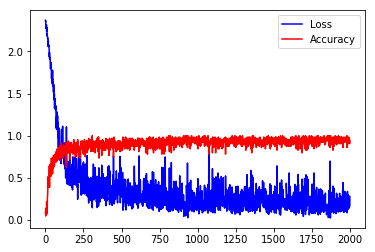

In [4]:
base_lr = 0.001
m_high = 0.9
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_multi_precision_sgd(
        model,
        nesterov=1,
        momentum=m_high,
        base_learning_rate=base_lr,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters_sgd_pr = 2000
accuracy_sgd_pr = np.zeros(total_iters_sgd_pr)
loss_sgd_pr = np.zeros(total_iters_sgd_pr)
printmd('**Training status: Running**  Wait till the process is completed')
for i in range(total_iters_sgd_pr):
    if(i%100 == 0):
        print "    Completed iterations:", i, ", Total iterations to be completed:", total_iters_sgd_pr
    workspace.RunNet(train_model.net)
    accuracy_sgd_pr[i] = workspace.blobs['accuracy']
    loss_sgd_pr[i] = workspace.blobs['loss']
#print "Training completed"
printmd('**Training status: Completed**')

#print "Testing status: Running"
printmd('**Testing status: Running**  Wait till the process is completed')
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_iters_sgd_pr = 1000
test_accuracy_sgd_pr = np.zeros(test_iters_sgd_pr)
for i in range(test_iters_sgd_pr):
    if(i%100 == 0):
        print "    Completed test set:", i, ", Total sets to be tested:", test_iters_sgd_pr
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy_sgd_pr[i] = workspace.FetchBlob('accuracy')
#print "Testing completed"
printmd('**Testing status: Completed**')
# After the execution is done, let's plot the values.
pyplot.plot(loss_sgd_pr, 'b')
pyplot.plot(accuracy_sgd_pr, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

**Effects of optimizers**

Solver Type,Num iterations,Init LR,Init Loss,Final Loss,Init Training-Acc(%),Final Training-Acc(%),Final Testing-Acc(%)
SGD,2000,0.0010,2.3395,0.1706,10.9375,93.7500,94.1900
Multi-Precision-SGD,2000,0.0010,2.3698,0.1656,9.3750,93.7500,94.5000


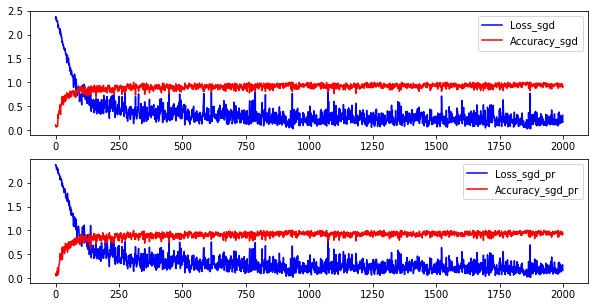

In [14]:
printmd('**Effects of optimizers**')

pyplot.figure(figsize=(10, 5))
pyplot.subplot(2,1,1)
pyplot.plot(loss_sgd, 'b')
pyplot.plot(accuracy_sgd, 'r')
pyplot.legend(('Loss_sgd', 'Accuracy_sgd'), loc='upper right')


pyplot.subplot(2,1,2)
pyplot.plot(loss_sgd_pr, 'b')
pyplot.plot(accuracy_sgd_pr, 'r')
pyplot.legend(('Loss_sgd_pr', 'Accuracy_sgd_pr'), loc='upper right')


solvers = [
    ['Solver Type', 'Num iterations', 'Init LR', 'Init Loss', 'Final Loss', 'Init Training-Acc(%)', \
     'Final Training-Acc(%)', 'Final Testing-Acc(%)'],
    ['SGD', total_iters_sgd, base_lr, loss_sgd[0], loss_sgd[total_iters_sgd-1], accuracy_sgd[0]*100, \
     accuracy_sgd[total_iters_sgd-1]*100, np.mean(test_accuracy_sgd)*100],
    ['Multi-Precision-SGD', total_iters_sgd, base_lr, loss_sgd_pr[0], loss_sgd_pr[total_iters_sgd_pr-1], \
     accuracy_sgd_pr[0]*100, accuracy_sgd_pr[total_iters_sgd_pr-1]*100, np.mean(test_accuracy_sgd_pr)*100]

];
make_table(solvers)
apply_theme('basic')
set_cell_style(2, 7, color='red')
set_cell_style(2, 0, color='red')

# Solver: Adam

**Training status: Running**  Wait till the process is completed

    Completed iterations: 0 , Total iterations to be completed: 1000
    Completed iterations: 100 , Total iterations to be completed: 1000
    Completed iterations: 200 , Total iterations to be completed: 1000
    Completed iterations: 300 , Total iterations to be completed: 1000
    Completed iterations: 400 , Total iterations to be completed: 1000
    Completed iterations: 500 , Total iterations to be completed: 1000
    Completed iterations: 600 , Total iterations to be completed: 1000
    Completed iterations: 700 , Total iterations to be completed: 1000
    Completed iterations: 800 , Total iterations to be completed: 1000
    Completed iterations: 900 , Total iterations to be completed: 1000


**Training status: Completed**

**Testing status: Running**  Wait till the process is completed

    Completed test set: 0 , Total sets to be tested: 1000
    Completed test set: 100 , Total sets to be tested: 1000
    Completed test set: 200 , Total sets to be tested: 1000
    Completed test set: 300 , Total sets to be tested: 1000
    Completed test set: 400 , Total sets to be tested: 1000
    Completed test set: 500 , Total sets to be tested: 1000
    Completed test set: 600 , Total sets to be tested: 1000
    Completed test set: 700 , Total sets to be tested: 1000
    Completed test set: 800 , Total sets to be tested: 1000
    Completed test set: 900 , Total sets to be tested: 1000


**Testing status: Completed**

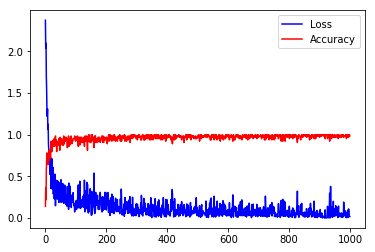

In [13]:
base_lr = 0.001
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_adam(
        model,
        base_learning_rate=base_lr, 
        beta1=0.9, 
        beta2=0.999, 
        epsilon=1e-8,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
workspace.ResetWorkspace()
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters_adam = 1000
accuracy_adam = np.zeros(total_iters_adam)
loss_adam = np.zeros(total_iters_adam)
printmd('**Training status: Running**  Wait till the process is completed')
for i in range(total_iters_adam):
    if(i%100 == 0):
        print "    Completed iterations:", i, ", Total iterations to be completed:", total_iters_adam
    workspace.RunNet(train_model.net)
    accuracy_adam[i] = workspace.blobs['accuracy']
    loss_adam[i] = workspace.blobs['loss']
#print "Training completed"
printmd('**Training status: Completed**')

#print "Testing status: Running"
printmd('**Testing status: Running**  Wait till the process is completed')
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_iters_adam = 1000
test_accuracy_adam = np.zeros(test_iters_adam)
for i in range(test_iters_adam):
    if(i%100 == 0):
        print "    Completed test set:", i, ", Total sets to be tested:", test_iters_adam
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy_adam[i] = workspace.FetchBlob('accuracy')
#print "Testing completed"
printmd('**Testing status: Completed**')
# After the execution is done, let's plot the values.
pyplot.plot(loss_adam, 'b')
pyplot.plot(accuracy_adam, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

In [5]:
printmd('**Effects of optimizers**')

pyplot.figure(figsize=(10, 5))
pyplot.subplot(3,1,1)
pyplot.plot(loss_sgd, 'b')
pyplot.plot(accuracy_sgd, 'r')
pyplot.legend(('Loss_sgd', 'Accuracy_sgd'), loc='upper right')


pyplot.subplot(3,1,2)
pyplot.plot(loss_sgd_pr, 'b')
pyplot.plot(accuracy_sgd_pr, 'r')
pyplot.legend(('Loss_sgd_pr', 'Accuracy_sgd_pr'), loc='upper right')

pyplot.subplot(3,1,3)
pyplot.plot(loss_adam, 'b')
pyplot.plot(accuracy_adam, 'r')
pyplot.legend(('Loss_adam', 'Accuracy_adam'), loc='upper right')


solvers = [
    ['Solver Type', 'Iterations to converge', 'Init LR', 'Init Loss', 'Final Loss', 'Init Training-Acc(%)', \
     'Final Training-Acc(%)', 'Final Testing-Acc(%)'],
    ['SGD', total_iters_sgd, base_lr, loss_sgd[0], loss_sgd[total_iters_sgd-1], accuracy_sgd[0]*100, \
     accuracy_sgd[total_iters_sgd-1]*100, np.mean(test_accuracy_sgd)*100],
    ['ADAM', total_iters_adam, base_lr, loss_adam[0], loss_adam[total_iters_adam-1], accuracy_adam[0]*100, \
     accuracy_adam[total_iters_adam-1]*100, np.mean(test_accuracy_adam)*100]

];
make_table(solvers)
apply_theme('basic')
set_cell_style(3, 7, color='red')
set_cell_style(3, 1, color='red')
set_cell_style(3, 0, color='yellow')

**Effects of optimizers**

NameError: name 'loss_sgd' is not defined

# Solver: Adagrad

**Training status: Running**  Wait till the process is completed

    Completed iterations: 0 , Total iterations to be completed: 3000
    Completed iterations: 100 , Total iterations to be completed: 3000
    Completed iterations: 200 , Total iterations to be completed: 3000
    Completed iterations: 300 , Total iterations to be completed: 3000
    Completed iterations: 400 , Total iterations to be completed: 3000
    Completed iterations: 500 , Total iterations to be completed: 3000
    Completed iterations: 600 , Total iterations to be completed: 3000
    Completed iterations: 700 , Total iterations to be completed: 3000
    Completed iterations: 800 , Total iterations to be completed: 3000
    Completed iterations: 900 , Total iterations to be completed: 3000
    Completed iterations: 1000 , Total iterations to be completed: 3000
    Completed iterations: 1100 , Total iterations to be completed: 3000
    Completed iterations: 1200 , Total iterations to be completed: 3000
    Completed iterations: 1300 , Total iterations to be completed: 3000
    

**Training status: Completed**

**Testing status: Running**  Wait till the process is completed

    Completed test set: 0 , Total sets to be tested: 1000
    Completed test set: 100 , Total sets to be tested: 1000
    Completed test set: 200 , Total sets to be tested: 1000
    Completed test set: 300 , Total sets to be tested: 1000
    Completed test set: 400 , Total sets to be tested: 1000
    Completed test set: 500 , Total sets to be tested: 1000
    Completed test set: 600 , Total sets to be tested: 1000
    Completed test set: 700 , Total sets to be tested: 1000
    Completed test set: 800 , Total sets to be tested: 1000
    Completed test set: 900 , Total sets to be tested: 1000


**Testing status: Completed**

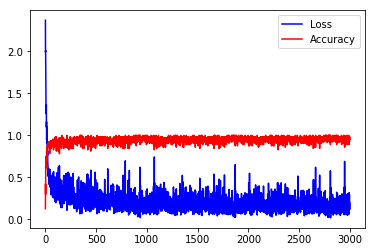

In [25]:
base_lr = 0.001
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_adagrad(
        model,
        base_learning_rate=base_lr, 
        decay=1, 
        epsilon=1e-4,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
workspace.ResetWorkspace()
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters_adagrad = 3000
accuracy_adagrad = np.zeros(total_iters_adagrad)
loss_adagrad = np.zeros(total_iters_adagrad)
printmd('**Training status: Running**  Wait till the process is completed')
for i in range(total_iters_adagrad):
    if(i%100 == 0):
        print "    Completed iterations:", i, ", Total iterations to be completed:", total_iters_adagrad
    workspace.RunNet(train_model.net)
    accuracy_adagrad[i] = workspace.blobs['accuracy']
    loss_adagrad[i] = workspace.blobs['loss']
#print "Training completed"
printmd('**Training status: Completed**')

#print "Testing status: Running"
printmd('**Testing status: Running**  Wait till the process is completed')
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_iters_adagrad = 1000
test_accuracy_adagrad = np.zeros(test_iters_adagrad)
for i in range(test_iters_adagrad):
    if(i%100 == 0):
        print "    Completed test set:", i, ", Total sets to be tested:", test_iters_adagrad
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy_adagrad[i] = workspace.FetchBlob('accuracy')
#print "Testing completed"
printmd('**Testing status: Completed**')
# After the execution is done, let's plot the values.
pyplot.plot(loss_adagrad, 'b')
pyplot.plot(accuracy_adagrad, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

**Effects of optimizers**

Solver Type,Iterations to converge,Init LR,Init Loss,Final Loss,Init Training-Acc(%),Final Training-Acc(%),Final Testing-Acc(%)
SGD,2000,0.0010,2.3395,0.1706,10.9375,93.7500,94.1900
Multi-Precision-SGD,2000,0.0010,2.3698,0.1656,9.3750,93.7500,94.5000
ADAM,1000,0.0010,2.3740,0.0167,14.0625,98.4375,98.6500
ADAGRAD,3000,0.0010,2.3726,0.1954,12.5000,95.3125,95.5900


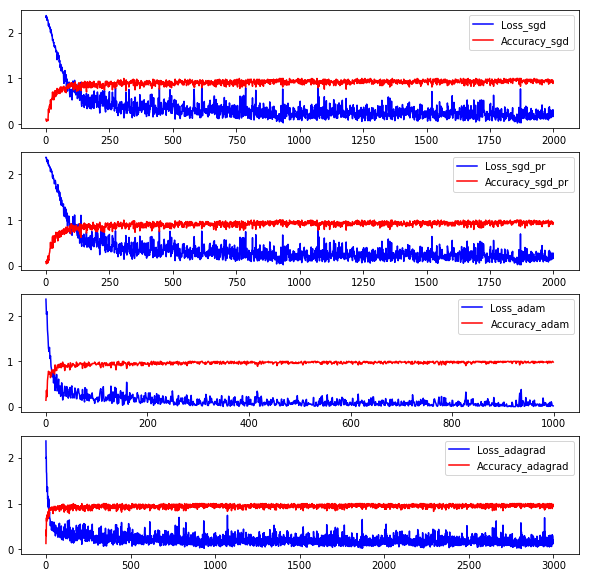

In [27]:
printmd('**Effects of optimizers**')

pyplot.figure(figsize=(10, 10))
pyplot.subplot(4,1,1)
pyplot.plot(loss_sgd, 'b')
pyplot.plot(accuracy_sgd, 'r')
pyplot.legend(('Loss_sgd', 'Accuracy_sgd'), loc='upper right')

pyplot.subplot(4,1,2)
pyplot.plot(loss_sgd_pr, 'b')
pyplot.plot(accuracy_sgd_pr, 'r')
pyplot.legend(('Loss_sgd_pr', 'Accuracy_sgd_pr'), loc='upper right')

pyplot.subplot(4,1,3)
pyplot.plot(loss_adam, 'b')
pyplot.plot(accuracy_adam, 'r')
pyplot.legend(('Loss_adam', 'Accuracy_adam'), loc='upper right')

pyplot.subplot(4,1,4)
pyplot.plot(loss_adagrad, 'b')
pyplot.plot(accuracy_adagrad, 'r')
pyplot.legend(('Loss_adagrad', 'Accuracy_adagrad'), loc='upper right')


solvers = [
    ['Solver Type', 'Iterations to converge', 'Init LR', 'Init Loss', 'Final Loss', 'Init Training-Acc(%)', \
     'Final Training-Acc(%)', 'Final Testing-Acc(%)'],
    ['SGD', total_iters_sgd, base_lr, loss_sgd[0], loss_sgd[total_iters_sgd-1], accuracy_sgd[0]*100, \
     accuracy_sgd[total_iters_sgd-1]*100, np.mean(test_accuracy_sgd)*100],
    ['Multi-Precision-SGD', total_iters_sgd, base_lr, loss_sgd_pr[0], loss_sgd_pr[total_iters_sgd_pr-1], \
     accuracy_sgd_pr[0]*100, accuracy_sgd_pr[total_iters_sgd_pr-1]*100, np.mean(test_accuracy_sgd_pr)*100],
    ['ADAM', total_iters_adam, base_lr, loss_adam[0], loss_adam[total_iters_adam-1], accuracy_adam[0]*100, \
     accuracy_adam[total_iters_adam-1]*100, np.mean(test_accuracy_adam)*100],
    ['ADAGRAD', total_iters_adagrad, base_lr, loss_adagrad[0], loss_adagrad[total_iters_adagrad-1], \
     accuracy_adagrad[0]*100, accuracy_adagrad[total_iters_adagrad-1]*100, np.mean(test_accuracy_adagrad)*100]

];
make_table(solvers)
apply_theme('basic')
set_cell_style(3, 7, color='red')
set_cell_style(3, 1, color='red')
set_cell_style(4, 1, color='yellow')
set_cell_style(4, 7, color='yellow')

# Solver: RMS-Prop



**Training status: Running**  Wait till the process is completed

    Completed iterations: 0 , Total iterations to be completed: 1500
    Completed iterations: 100 , Total iterations to be completed: 1500
    Completed iterations: 200 , Total iterations to be completed: 1500
    Completed iterations: 300 , Total iterations to be completed: 1500
    Completed iterations: 400 , Total iterations to be completed: 1500
    Completed iterations: 500 , Total iterations to be completed: 1500
    Completed iterations: 600 , Total iterations to be completed: 1500
    Completed iterations: 700 , Total iterations to be completed: 1500
    Completed iterations: 800 , Total iterations to be completed: 1500
    Completed iterations: 900 , Total iterations to be completed: 1500
    Completed iterations: 1000 , Total iterations to be completed: 1500
    Completed iterations: 1100 , Total iterations to be completed: 1500
    Completed iterations: 1200 , Total iterations to be completed: 1500
    Completed iterations: 1300 , Total iterations to be completed: 1500
    

**Training status: Completed**

**Testing status: Running**  Wait till the process is completed

    Completed test set: 0 , Total sets to be tested: 1000
    Completed test set: 100 , Total sets to be tested: 1000
    Completed test set: 200 , Total sets to be tested: 1000
    Completed test set: 300 , Total sets to be tested: 1000
    Completed test set: 400 , Total sets to be tested: 1000
    Completed test set: 500 , Total sets to be tested: 1000
    Completed test set: 600 , Total sets to be tested: 1000
    Completed test set: 700 , Total sets to be tested: 1000
    Completed test set: 800 , Total sets to be tested: 1000
    Completed test set: 900 , Total sets to be tested: 1000


**Testing status: Completed**

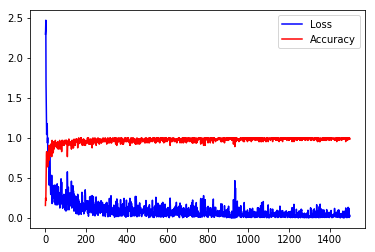

In [31]:
base_lr = 0.001
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_rms_prop(
        model,
        base_learning_rate=base_lr, 
        decay=0.9, 
        momentum=0.9,
        epsilon=1e-5,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
workspace.ResetWorkspace()
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters_rmsprop = 1500
accuracy_rmsprop = np.zeros(total_iters_rmsprop)
loss_rmsprop = np.zeros(total_iters_rmsprop)
printmd('**Training status: Running**  Wait till the process is completed')
for i in range(total_iters_rmsprop):
    if(i%100 == 0):
        print "    Completed iterations:", i, ", Total iterations to be completed:", total_iters_rmsprop
    workspace.RunNet(train_model.net)
    accuracy_rmsprop[i] = workspace.blobs['accuracy']
    loss_rmsprop[i] = workspace.blobs['loss']
#print "Training completed"
printmd('**Training status: Completed**')

#print "Testing status: Running"
printmd('**Testing status: Running**  Wait till the process is completed')
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_iters_rmsprop = 1000
test_accuracy_rmsprop = np.zeros(test_iters_rmsprop)
for i in range(test_iters_rmsprop):
    if(i%100 == 0):
        print "    Completed test set:", i, ", Total sets to be tested:", test_iters_rmsprop
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy_rmsprop[i] = workspace.FetchBlob('accuracy')
#print "Testing completed"
printmd('**Testing status: Completed**')
# After the execution is done, let's plot the values.
pyplot.plot(loss_rmsprop, 'b')
pyplot.plot(accuracy_rmsprop, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

**Effects of optimizers**

Solver Type,Iterations to converge,Init LR,Init Loss,Final Loss,Init Training-Acc(%),Final Training-Acc(%),Final Testing-Acc(%)
SGD,2000,0.0010,2.3395,0.1706,10.9375,93.7500,94.1900
Multi-Precision-SGD,2000,0.0010,2.3698,0.1656,9.3750,93.7500,94.5000
ADAM,1000,0.0010,2.3740,0.0167,14.0625,98.4375,98.6500
ADAGRAD,3000,0.0010,2.3726,0.1954,12.5000,95.3125,95.5900
RMSPROP,1500,0.0010,2.2954,0.0320,15.6250,98.4375,98.6700


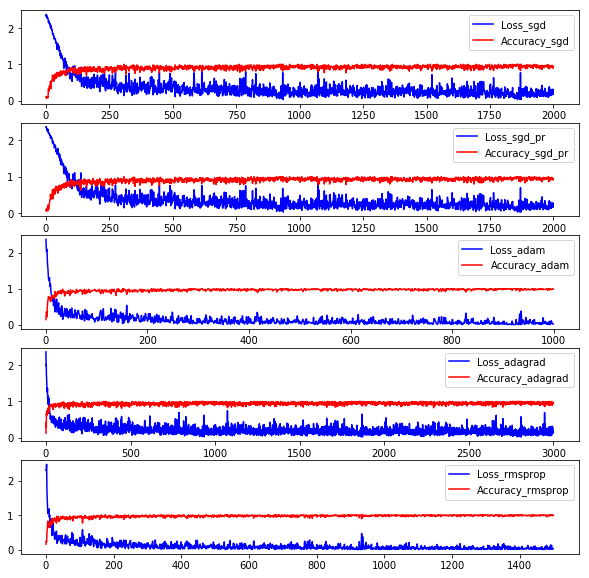

In [33]:
printmd('**Effects of optimizers**')

pyplot.figure(figsize=(10, 10))
pyplot.subplot(5,1,1)
pyplot.plot(loss_sgd, 'b')
pyplot.plot(accuracy_sgd, 'r')
pyplot.legend(('Loss_sgd', 'Accuracy_sgd'), loc='upper right')

pyplot.subplot(5,1,2)
pyplot.plot(loss_sgd_pr, 'b')
pyplot.plot(accuracy_sgd_pr, 'r')
pyplot.legend(('Loss_sgd_pr', 'Accuracy_sgd_pr'), loc='upper right')

pyplot.subplot(5,1,3)
pyplot.plot(loss_adam, 'b')
pyplot.plot(accuracy_adam, 'r')
pyplot.legend(('Loss_adam', 'Accuracy_adam'), loc='upper right')

pyplot.subplot(5,1,4)
pyplot.plot(loss_adagrad, 'b')
pyplot.plot(accuracy_adagrad, 'r')
pyplot.legend(('Loss_adagrad', 'Accuracy_adagrad'), loc='upper right')

pyplot.subplot(5,1,5)
pyplot.plot(loss_rmsprop, 'b')
pyplot.plot(accuracy_rmsprop, 'r')
pyplot.legend(('Loss_rmsprop', 'Accuracy_rmsprop'), loc='upper right')


solvers = [
    ['Solver Type', 'Iterations to converge', 'Init LR', 'Init Loss', 'Final Loss', 'Init Training-Acc(%)', \
     'Final Training-Acc(%)', 'Final Testing-Acc(%)'],
    ['SGD', total_iters_sgd, base_lr, loss_sgd[0], loss_sgd[total_iters_sgd-1], accuracy_sgd[0]*100, \
     accuracy_sgd[total_iters_sgd-1]*100, np.mean(test_accuracy_sgd)*100],
    ['Multi-Precision-SGD', total_iters_sgd, base_lr, loss_sgd_pr[0], loss_sgd_pr[total_iters_sgd_pr-1], \
     accuracy_sgd_pr[0]*100, accuracy_sgd_pr[total_iters_sgd_pr-1]*100, np.mean(test_accuracy_sgd_pr)*100],
    ['ADAM', total_iters_adam, base_lr, loss_adam[0], loss_adam[total_iters_adam-1], accuracy_adam[0]*100, \
     accuracy_adam[total_iters_adam-1]*100, np.mean(test_accuracy_adam)*100],
    ['ADAGRAD', total_iters_adagrad, base_lr, loss_adagrad[0], loss_adagrad[total_iters_adagrad-1], \
     accuracy_adagrad[0]*100, accuracy_adagrad[total_iters_adagrad-1]*100, np.mean(test_accuracy_adagrad)*100],
    ['RMSPROP', total_iters_rmsprop, base_lr, loss_rmsprop[0], loss_rmsprop[total_iters_rmsprop-1], \
     accuracy_rmsprop[0]*100, accuracy_rmsprop[total_iters_rmsprop-1]*100, np.mean(test_accuracy_rmsprop)*100]

];
make_table(solvers)
apply_theme('basic')
set_cell_style(3, 7, color='yellow')
set_cell_style(3, 1, color='yellow')
set_cell_style(5, 1, color='red')
set_cell_style(5, 7, color='red')

**Training status: Running**  Wait till the process is completed

    Completed iterations: 0 , Total iterations to be completed: 3000
    Completed iterations: 100 , Total iterations to be completed: 3000
    Completed iterations: 200 , Total iterations to be completed: 3000
    Completed iterations: 300 , Total iterations to be completed: 3000
    Completed iterations: 400 , Total iterations to be completed: 3000
    Completed iterations: 500 , Total iterations to be completed: 3000
    Completed iterations: 600 , Total iterations to be completed: 3000
    Completed iterations: 700 , Total iterations to be completed: 3000
    Completed iterations: 800 , Total iterations to be completed: 3000
    Completed iterations: 900 , Total iterations to be completed: 3000
    Completed iterations: 1000 , Total iterations to be completed: 3000
    Completed iterations: 1100 , Total iterations to be completed: 3000
    Completed iterations: 1200 , Total iterations to be completed: 3000
    Completed iterations: 1300 , Total iterations to be completed: 3000
    

**Training status: Completed**

**Testing status: Running**  Wait till the process is completed

    Completed test set: 0 , Total sets to be tested: 1000
    Completed test set: 100 , Total sets to be tested: 1000
    Completed test set: 200 , Total sets to be tested: 1000
    Completed test set: 300 , Total sets to be tested: 1000
    Completed test set: 400 , Total sets to be tested: 1000
    Completed test set: 500 , Total sets to be tested: 1000
    Completed test set: 600 , Total sets to be tested: 1000
    Completed test set: 700 , Total sets to be tested: 1000
    Completed test set: 800 , Total sets to be tested: 1000
    Completed test set: 900 , Total sets to be tested: 1000


**Testing status: Completed**

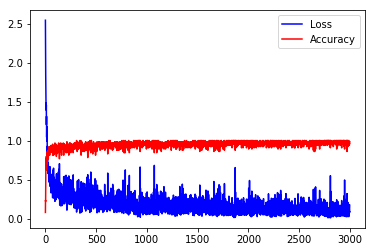

In [40]:
base_lr = 0.001
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_ftrl(
        model,
        engine="CPU",
        alpha=base_lr,
        beta=1e-4,
        lambda1=0., 
        lambda2=0.,
    )
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
workspace.ResetWorkspace()
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters_ftrl = 3000
accuracy_ftrl = np.zeros(total_iters_ftrl)
loss_ftrl = np.zeros(total_iters_ftrl)
printmd('**Training status: Running**  Wait till the process is completed')
for i in range(total_iters_ftrl):
    if(i%100 == 0):
        print "    Completed iterations:", i, ", Total iterations to be completed:", total_iters_ftrl
    workspace.RunNet(train_model.net)
    accuracy_ftrl[i] = workspace.blobs['accuracy']
    loss_ftrl[i] = workspace.blobs['loss']
#print "Training completed"
printmd('**Training status: Completed**')

#print "Testing status: Running"
printmd('**Testing status: Running**  Wait till the process is completed')
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_iters_ftrl = 1000
test_accuracy_ftrl = np.zeros(test_iters_ftrl)
for i in range(test_iters_ftrl):
    if(i%100 == 0):
        print "    Completed test set:", i, ", Total sets to be tested:", test_iters_ftrl
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy_ftrl[i] = workspace.FetchBlob('accuracy')
#print "Testing completed"
printmd('**Testing status: Completed**')
# After the execution is done, let's plot the values.
pyplot.plot(loss_ftrl, 'b')
pyplot.plot(accuracy_ftrl, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

**Effects of optimizers**

Solver Type,Iterations to converge,Init LR,Init Loss,Final Loss,Init Training-Acc(%),Final Training-Acc(%),Final Testing-Acc(%)
SGD,2000,0.0010,2.3395,0.1706,10.9375,93.7500,94.1900
Multi-Precision-SGD,2000,0.0010,2.3698,0.1656,9.3750,93.7500,94.5000
ADAM,1000,0.0010,2.3740,0.0167,14.0625,98.4375,98.6500
ADAGRAD,3000,0.0010,2.3726,0.1954,12.5000,95.3125,95.5900
RMSPROP,1500,0.0010,2.2954,0.0320,15.6250,98.4375,98.6700
FTRL,3000,0.0010,2.5421,0.0839,7.8125,98.4375,96.7700


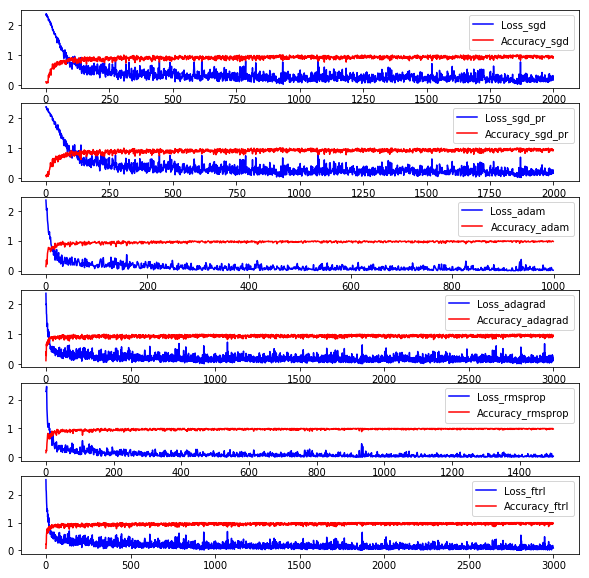

In [41]:
printmd('**Effects of optimizers**')

pyplot.figure(figsize=(10, 10))
pyplot.subplot(6,1,1)
pyplot.plot(loss_sgd, 'b')
pyplot.plot(accuracy_sgd, 'r')
pyplot.legend(('Loss_sgd', 'Accuracy_sgd'), loc='upper right')

pyplot.subplot(6,1,2)
pyplot.plot(loss_sgd_pr, 'b')
pyplot.plot(accuracy_sgd_pr, 'r')
pyplot.legend(('Loss_sgd_pr', 'Accuracy_sgd_pr'), loc='upper right')

pyplot.subplot(6,1,3)
pyplot.plot(loss_adam, 'b')
pyplot.plot(accuracy_adam, 'r')
pyplot.legend(('Loss_adam', 'Accuracy_adam'), loc='upper right')

pyplot.subplot(6,1,4)
pyplot.plot(loss_adagrad, 'b')
pyplot.plot(accuracy_adagrad, 'r')
pyplot.legend(('Loss_adagrad', 'Accuracy_adagrad'), loc='upper right')

pyplot.subplot(6,1,5)
pyplot.plot(loss_rmsprop, 'b')
pyplot.plot(accuracy_rmsprop, 'r')
pyplot.legend(('Loss_rmsprop', 'Accuracy_rmsprop'), loc='upper right')

pyplot.subplot(6,1,6)
pyplot.plot(loss_ftrl, 'b')
pyplot.plot(accuracy_ftrl, 'r')
pyplot.legend(('Loss_ftrl', 'Accuracy_ftrl'), loc='upper right')


solvers = [
    ['Solver Type', 'Iterations to converge', 'Init LR', 'Init Loss', 'Final Loss', 'Init Training-Acc(%)', \
     'Final Training-Acc(%)', 'Final Testing-Acc(%)'],
    ['SGD', total_iters_sgd, base_lr, loss_sgd[0], loss_sgd[total_iters_sgd-1], accuracy_sgd[0]*100, \
     accuracy_sgd[total_iters_sgd-1]*100, np.mean(test_accuracy_sgd)*100],
    ['Multi-Precision-SGD', total_iters_sgd, base_lr, loss_sgd_pr[0], loss_sgd_pr[total_iters_sgd_pr-1], \
     accuracy_sgd_pr[0]*100, accuracy_sgd_pr[total_iters_sgd_pr-1]*100, np.mean(test_accuracy_sgd_pr)*100],
    ['ADAM', total_iters_adam, base_lr, loss_adam[0], loss_adam[total_iters_adam-1], accuracy_adam[0]*100, \
     accuracy_adam[total_iters_adam-1]*100, np.mean(test_accuracy_adam)*100],
    ['ADAGRAD', total_iters_adagrad, base_lr, loss_adagrad[0], loss_adagrad[total_iters_adagrad-1], \
     accuracy_adagrad[0]*100, accuracy_adagrad[total_iters_adagrad-1]*100, np.mean(test_accuracy_adagrad)*100],
    ['RMSPROP', total_iters_rmsprop, base_lr, loss_rmsprop[0], loss_rmsprop[total_iters_rmsprop-1], \
     accuracy_rmsprop[0]*100, accuracy_rmsprop[total_iters_rmsprop-1]*100, np.mean(test_accuracy_rmsprop)*100],
    ['FTRL', total_iters_ftrl, base_lr, loss_ftrl[0], loss_ftrl[total_iters_ftrl-1], \
     accuracy_ftrl[0]*100, accuracy_ftrl[total_iters_ftrl-1]*100, np.mean(test_accuracy_ftrl)*100]

];
make_table(solvers)
apply_theme('basic')
set_cell_style(3, 7, color='yellow')
set_cell_style(3, 1, color='yellow')
set_cell_style(5, 1, color='red')
set_cell_style(5, 7, color='red')

**Training status: Running**  Wait till the process is completed

    Completed iterations: 0 , Total iterations to be completed: 1000
    Completed iterations: 100 , Total iterations to be completed: 1000
    Completed iterations: 200 , Total iterations to be completed: 1000
    Completed iterations: 300 , Total iterations to be completed: 1000
    Completed iterations: 400 , Total iterations to be completed: 1000
    Completed iterations: 500 , Total iterations to be completed: 1000
    Completed iterations: 600 , Total iterations to be completed: 1000
    Completed iterations: 700 , Total iterations to be completed: 1000
    Completed iterations: 800 , Total iterations to be completed: 1000
    Completed iterations: 900 , Total iterations to be completed: 1000


**Training status: Completed**

**Testing status: Running**  Wait till the process is completed

    Completed test set: 0 , Total sets to be tested: 1000
    Completed test set: 100 , Total sets to be tested: 1000
    Completed test set: 200 , Total sets to be tested: 1000
    Completed test set: 300 , Total sets to be tested: 1000
    Completed test set: 400 , Total sets to be tested: 1000
    Completed test set: 500 , Total sets to be tested: 1000
    Completed test set: 600 , Total sets to be tested: 1000
    Completed test set: 700 , Total sets to be tested: 1000
    Completed test set: 800 , Total sets to be tested: 1000
    Completed test set: 900 , Total sets to be tested: 1000


**Testing status: Completed**

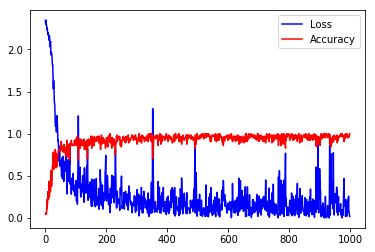

In [54]:
base_lr = 0.001
base_lr_yellowfin = 0.01
def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_yellowfin(
        model,
        base_learning_rate=base_lr_yellowfin, 
        mu=0.0,
        beta=0.999,
        curv_win_width=20,
        zero_debias=True,
        epsilon=0.1**6,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
workspace.ResetWorkspace()
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters_yellowfin = 1000
accuracy_yellowfin = np.zeros(total_iters_yellowfin)
loss_yellowfin = np.zeros(total_iters_yellowfin)
printmd('**Training status: Running**  Wait till the process is completed')
for i in range(total_iters_yellowfin):
    if(i%100 == 0):
        print "    Completed iterations:", i, ", Total iterations to be completed:", total_iters_yellowfin
    workspace.RunNet(train_model.net)
    accuracy_yellowfin[i] = workspace.blobs['accuracy']
    loss_yellowfin[i] = workspace.blobs['loss']
#print "Training completed"
printmd('**Training status: Completed**')

#print "Testing status: Running"
printmd('**Testing status: Running**  Wait till the process is completed')
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_iters_yellowfin = 1000
test_accuracy_yellowfin = np.zeros(test_iters_yellowfin)
for i in range(test_iters_yellowfin):
    if(i%100 == 0):
        print "    Completed test set:", i, ", Total sets to be tested:", test_iters_yellowfin
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy_yellowfin[i] = workspace.FetchBlob('accuracy')
#print "Testing completed"
printmd('**Testing status: Completed**')
# After the execution is done, let's plot the values.
pyplot.plot(loss_yellowfin, 'b')
pyplot.plot(accuracy_yellowfin, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

**Effects of optimizers**

Solver Type,Iterations to converge,Init LR,Init Loss,Final Loss,Init Training-Acc(%),Final Training-Acc(%),Final Testing-Acc(%)
SGD,2000,0.0010,2.3395,0.1706,10.9375,93.7500,94.1900
Multi-Precision-SGD,2000,0.0010,2.3698,0.1656,9.3750,93.7500,94.5000
ADAM,1000,0.0010,2.3740,0.0167,14.0625,98.4375,98.6500
ADAGRAD,3000,0.0010,2.3726,0.1954,12.5000,95.3125,95.5900
RMSPROP,1500,0.0010,2.2954,0.0320,15.6250,98.4375,98.6700
FTRL,3000,0.0010,2.5421,0.0839,7.8125,98.4375,96.7700
YELLOWFIN,1000,0.0100,2.3442,0.0161,4.6875,100.0000,96.8900


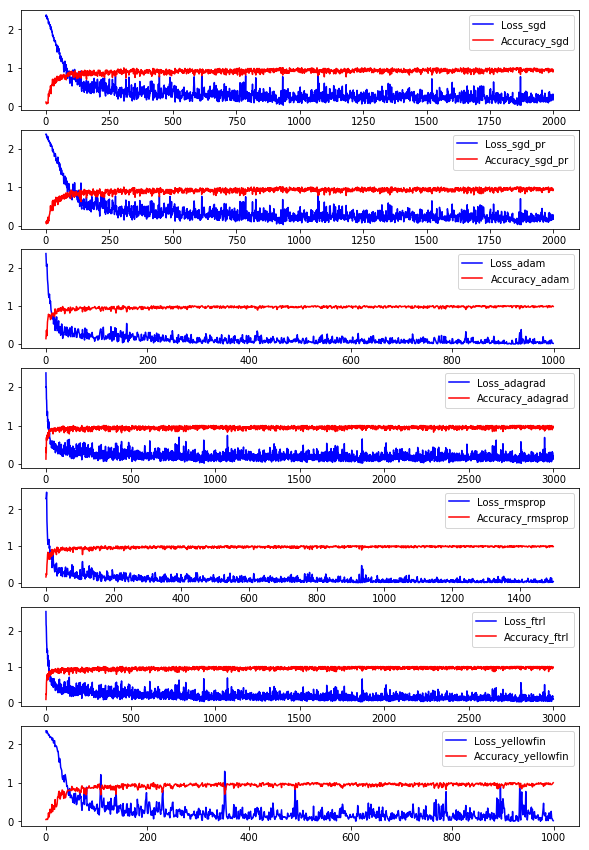

In [56]:
printmd('**Effects of optimizers**')

pyplot.figure(figsize=(10, 15))
pyplot.subplot(7,1,1)
pyplot.plot(loss_sgd, 'b')
pyplot.plot(accuracy_sgd, 'r')
pyplot.legend(('Loss_sgd', 'Accuracy_sgd'), loc='upper right')

pyplot.subplot(7,1,2)
pyplot.plot(loss_sgd_pr, 'b')
pyplot.plot(accuracy_sgd_pr, 'r')
pyplot.legend(('Loss_sgd_pr', 'Accuracy_sgd_pr'), loc='upper right')

pyplot.subplot(7,1,3)
pyplot.plot(loss_adam, 'b')
pyplot.plot(accuracy_adam, 'r')
pyplot.legend(('Loss_adam', 'Accuracy_adam'), loc='upper right')

pyplot.subplot(7,1,4)
pyplot.plot(loss_adagrad, 'b')
pyplot.plot(accuracy_adagrad, 'r')
pyplot.legend(('Loss_adagrad', 'Accuracy_adagrad'), loc='upper right')

pyplot.subplot(7,1,5)
pyplot.plot(loss_rmsprop, 'b')
pyplot.plot(accuracy_rmsprop, 'r')
pyplot.legend(('Loss_rmsprop', 'Accuracy_rmsprop'), loc='upper right')

pyplot.subplot(7,1,6)
pyplot.plot(loss_ftrl, 'b')
pyplot.plot(accuracy_ftrl, 'r')
pyplot.legend(('Loss_ftrl', 'Accuracy_ftrl'), loc='upper right')

pyplot.subplot(7,1,7)
pyplot.plot(loss_yellowfin, 'b')
pyplot.plot(accuracy_yellowfin, 'r')
pyplot.legend(('Loss_yellowfin', 'Accuracy_yellowfin'), loc='upper right')


solvers = [
    ['Solver Type', 'Iterations to converge', 'Init LR', 'Init Loss', 'Final Loss', 'Init Training-Acc(%)', \
     'Final Training-Acc(%)', 'Final Testing-Acc(%)'],
    ['SGD', total_iters_sgd, base_lr, loss_sgd[0], loss_sgd[total_iters_sgd-1], accuracy_sgd[0]*100, \
     accuracy_sgd[total_iters_sgd-1]*100, np.mean(test_accuracy_sgd)*100],
    ['Multi-Precision-SGD', total_iters_sgd, base_lr, loss_sgd_pr[0], loss_sgd_pr[total_iters_sgd_pr-1], \
     accuracy_sgd_pr[0]*100, accuracy_sgd_pr[total_iters_sgd_pr-1]*100, np.mean(test_accuracy_sgd_pr)*100],
    ['ADAM', total_iters_adam, base_lr, loss_adam[0], loss_adam[total_iters_adam-1], accuracy_adam[0]*100, \
     accuracy_adam[total_iters_adam-1]*100, np.mean(test_accuracy_adam)*100],
    ['ADAGRAD', total_iters_adagrad, base_lr, loss_adagrad[0], loss_adagrad[total_iters_adagrad-1], \
     accuracy_adagrad[0]*100, accuracy_adagrad[total_iters_adagrad-1]*100, np.mean(test_accuracy_adagrad)*100],
    ['RMSPROP', total_iters_rmsprop, base_lr, loss_rmsprop[0], loss_rmsprop[total_iters_rmsprop-1], \
     accuracy_rmsprop[0]*100, accuracy_rmsprop[total_iters_rmsprop-1]*100, np.mean(test_accuracy_rmsprop)*100],
    ['FTRL', total_iters_ftrl, base_lr, loss_ftrl[0], loss_ftrl[total_iters_ftrl-1], \
     accuracy_ftrl[0]*100, accuracy_ftrl[total_iters_ftrl-1]*100, np.mean(test_accuracy_ftrl)*100], 
    ['YELLOWFIN', total_iters_yellowfin, base_lr_yellowfin, loss_yellowfin[0], loss_yellowfin[total_iters_yellowfin-1], \
     accuracy_yellowfin[0]*100, accuracy_yellowfin[total_iters_yellowfin-1]*100, np.mean(test_accuracy_yellowfin)*100]

];
make_table(solvers)
apply_theme('basic')
set_cell_style(3, 7, color='yellow')
set_cell_style(3, 1, color='yellow')
set_cell_style(5, 1, color='red')
set_cell_style(5, 7, color='red')
set_cell_style(7, 7, color='green')
set_cell_style(7, 2, color='green')